# Projeto de AAED 2018-1

Top 12 dataset mais populares no UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/index.php), este trabalho visa apresentar como utilizar alguma técnicas de Machine Learning e tirar o melhor proveito de cada uma delas. Ainda, uma análise mais detalhada de cada uma.

# Introdução
Esta análise é composta pela abordagem de:

 - Interpretação dos dados;
 - Algoritmos de Aprendizado de Máquina (Machine Learning) para enriquecer os dados;
 - Técnicas de Aprendizado de Máquina para classificação;
 - Uso de bibliotecas *Open-Source* para desenvolvimento;
 - E métricas para mensurar resultados.

# Descrição do conjunto de dados

Com um conjunto de dados de 1.025.010 mãos de poker, os dados estão representados em dois formatos: **(a) Categório** e **(b)Ordinal**.

 - S1 "Tipo da Carta 1" &rightarrow; Ordinal (1-4) representando os Naipes (♥♦♣♠);
 - C1 "Rank da Carta 1" &rightarrow; Numérico (1-13) representando: As, 2, 3, ... , Rainha, Rei.
 
E classificados em 10 classes:
 - 0 : Nada na mão; não é uma mão de poker reconhecida;
 - 1 : Um par; um par de fileiras iguais dentro de cinco cartas;
 - 2 : Dois pares; dois pares de fileiras iguais dentro de cinco cartas;
 - 3 : Três de um tipo; três fileiras iguais dentro de cinco cartas;
 - 4 : Em linha reta; cinco cartas, sequencialmente classificadas sem lacunas;
 - 5 : Flush; cinco cartas com o mesmo naipe;
 - 6 : Casa cheia; par + classificação diferente três de um tipo;
 - 7 : Quatro de um tipo; quatro fileiras iguais dentro de cinco cartas;
 - 8 : Straight flush; straight + flush;
 - 9 : Royal flush; Ás, Rei, Rainha, Valete, Dez + flush

## Distruibuição dos dados em suas classes
| Poker Hand      | Classe | Treino | Teste |
| :-------------: | :----: | :----: | :---: |
| Nothing in hand | 0      | 49.9   | 50.12 |
| One pair        | 1      | 42.3   | 42.24 |
| Two pairs       | 2      | 4.8    | 4.76  |
| Three of a kind | 3      | 2.0    | 2.11  |
| Straight        | 4      | 0.3    | 0.38  |
| Flush           | 5      | 0.2    | 0.19  |
| Full house      | 6      | 0.1    | 0.14  |
| Four of a kind  | 7      | 0.0    | 0.02  |
| Straight flush  | 8      | 0.0    | 0.00  |
| Royal flush     | 9      | 0.0    | 0.00  |

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
import time

## Métricas

In [2]:
from sklearn import metrics
from sklearn.preprocessing import label_binarize

## Plots

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Ignorar Warning durante processamento

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

## Aprendizado de Máquina - Machine Learning

### Scikit-Learn

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

### Keras e TensorFlow

In [5]:
# Our deep learning library is Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras import callbacks
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Funções auxiliares

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def plot_roc_curve(y_test, y_score, labels, classes=[0,1,2,3,4,5,6,7,8,9]):
    y = label_binarize(y_test, classes=classes)
    # Compute ROC curve and ROC area for each class
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    # Plot of a ROC curve for a specific class
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
    fig.subplots_adjust(hspace = .25, wspace=.25)
    axs = axs.ravel()
    for ax,i in zip(axs.flat, range(n_classes)):
        ax.plot((fpr[i]*100), (tpr[i]*100), label='ROC curve (area = %0.2f)' % (roc_auc[i]*100))
        ax.plot([0, 100], [0, 100], 'k--')
        ax.set_xlim([0.0, 100.0])
        ax.set_ylim([0.0, 105.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(labels[i])
        ax.legend(loc="lower right")

In [8]:
def plot_accuracy_nn(model_results, title='model accuracy'):
    plt.plot(model_results.history['acc'])
    if 'val_acc' in model_results.history:
        plt.plot(model_results.history['val_acc'])
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=2.0)

In [9]:
def plot_pie_distrib(df, labels=[]):
    sizes = df.groupby(['CLASS'])['CLASS'].count()
    # Plot
    patches, texts = plt.pie(sizes, labels=labels)
    #plt.legend(patches, poker_hand, loc="best")
    plt.legend( loc = 'left', 
               labels=['%s, %1.4f' % (l, s/df.shape[0] * 100) 
                       for l, s in zip(labels, sizes)])

    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [10]:
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Datasets

## Carregando os dados

In [13]:
train = pd.read_csv('./data/poker-hand-training.data.zip', names=columns_names, compression='zip')

In [14]:
test = pd.read_csv('./data/poker-hand-testing.data.zip', names=columns_names, compression='zip')

### Nomeando as colunas

In [12]:
columns_names = ["S1","C1","S2","C2","S3","C3","S4","C4","S5","C5","CLASS"]

## Identificando cada uma das Classes

In [11]:
poker_hand = [
    "Nothing in hand" , "One pair"   , "Two pairs"      , "Three of a kind" , "Straight"    ,
    "Flush"           , "Full house" , "Four of a kind" , "Straight flush"  , "Royal flush"
]

### Adicionando nomenclatura para as classes

In [15]:
train['poker_hand'] = train['CLASS'].apply(lambda x: poker_hand[x])

In [16]:
test['poker_hand'] = test['CLASS'].apply(lambda x: poker_hand[x])

## Exibindo alguns registros aleatórios do dataset de Treino

In [18]:
train.sample(n=5)

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,CLASS,poker_hand
21932,1,2,3,2,4,4,3,12,1,8,1,One pair
23571,1,11,2,6,1,10,4,5,4,9,0,Nothing in hand
16331,1,10,4,9,4,4,1,7,3,10,1,One pair
2690,1,5,2,11,2,12,1,6,4,9,0,Nothing in hand
10218,3,9,2,3,4,8,1,5,2,7,0,Nothing in hand


## Distribuição dos dados

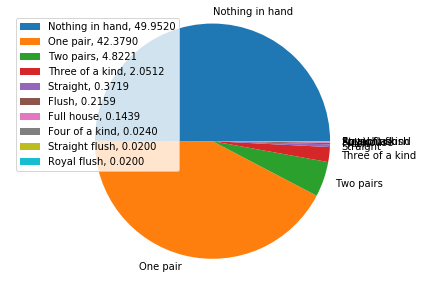

In [19]:
plot_pie_distrib(train, poker_hand)

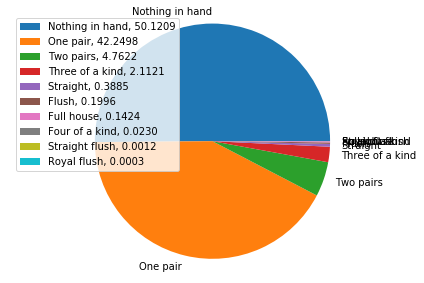

In [20]:
plot_pie_distrib(test, poker_hand)

# Preparação dos Datasets

Nesta etapa é necessário a preparação dos dados para treino e teste das classes

In [17]:
# Treino
X_train = train[['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']]
y_train = train['CLASS']

# Teste
X_test = test[['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']]
y_test = test['CLASS']

# Cross-Validation e Hyperparameters

Antes de passar pelas técnicas de ML, existe alguns pontos interessantes para se atentar.

## Cross-Validation

A técnica de *Cross-Validation*, ou Validação Cruzada, visa trabalhar o *dataset* de treinamento de forma a dividir em **k** blocos proporcionais e utilizar parte dos blocos no treinamento do modelo preditivo e parte para validação do mesmo.

Essa abordagem visa um melhor aproveitamento dos blocos para o momento de treinamento, os quais podem apresentar maiores características aderentes a cada uma das classes do *dataset*.

As técnicas utilizadas normalmente na área são:
 - KFold
 - StratifiedKFold
 - ShuffleSplit
 - **StratifiedShuffleSplit**

## Hyperparameters

A figura abaixo descreve a complexidade, através da escolha de apenas 2 parâmetros e seus devidos valores, como explorar e obter as melhores combinações para cada técnica.

Três técnicas mais utilizadas, para a escolha dos valores de cada dos valores mais adequados para este trabalho:
 - Grid Search
 - Gradient Descent
 - **Randomized Search**

<center><img src="./img/weightiterations.jpg" alt="Weight Iterations" width="45%"/></center>

# Métricas

|Acurácia, Precision, Recall|  ROC Curve (*Receiver Operating Characteristic*)|
|:-------------------------:|:-------------------------:|
|![Acurácia, Precision, Recall (Sensitivity)](./img/acc_prec_recall.jpg)  |  ![ROC Curve](./img/ROC_curves.png)|

# Random Forest

Criado como uma variação da *Decision Tree*, *Random Forest* é comumente utilizado quando o problema abordado existe diversas classes.

Com um custo computacional de $O(nTree*v*n*log(n))$, onde os valores representam:
 - $nTree$ &rightarrow; número de DTs;
 - $v$ &rightarrow; número de atributos;
 - $n$ &rightarrow; números de registros

In [22]:
param_grid = dict(n_estimators=np.random.randint(1,100, size=30),
                  max_depth=np.random.randint(3,10, size=5),
                  criterion=['gini', 'entropy'], 
                  max_features=['auto','log2',None],
                  oob_score=[False, True])

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
clf = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), 
                         param_distributions=param_grid, 
                         cv=cv, 
                         verbose=1, 
                         n_jobs=1)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.2s finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': array([19, 55, 57, 78, 87, 41, 61, 90, 85, 20, 81, 25, 94, 31, 73, 60, 47,
       97, 51, 39, 58, 98, 41, 15, 48, 10, 56,  2,  8,  8]), 'max_depth': array([4, 6, 7, 8, 7]), 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'log2', None], 'oob_score': [False, True]},
          pre_dispatch='

In [23]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [24]:
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'oob_score': True, 'n_estimators': 60, 'max_features': None, 'max_depth': 8, 'criterion': 'entropy'} with a score of 0.60


In [25]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [27]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

## Avaliando resultados do modelo treinado

In [28]:
y_pred = clf.predict(X_test)

### Acurária e métricas internas de cada classe

In [30]:
print("Acurácia = ", (metrics.accuracy_score(y_test, y_pred) * 100))
print("Precisão e Recall para cada Classe")
print(metrics.classification_report(y_test, y_pred))

Acurácia =  59.838
Precisão e Recall para cada Classe
             precision    recall  f1-score   support

          0       0.60      0.87      0.71    501209
          1       0.58      0.39      0.46    422498
          2       0.56      0.00      0.00     47622
          3       0.38      0.00      0.00     21121
          4       0.00      0.00      0.00      3885
          5       0.00      0.00      0.00      1996
          6       0.00      0.00      0.00      1424
          7       0.00      0.00      0.00       230
          8       0.00      0.00      0.00        12
          9       0.00      0.00      0.00         3

avg / total       0.58      0.60      0.55   1000000



### ROC Curve

In [31]:
y_score = clf.predict_proba(X_test)

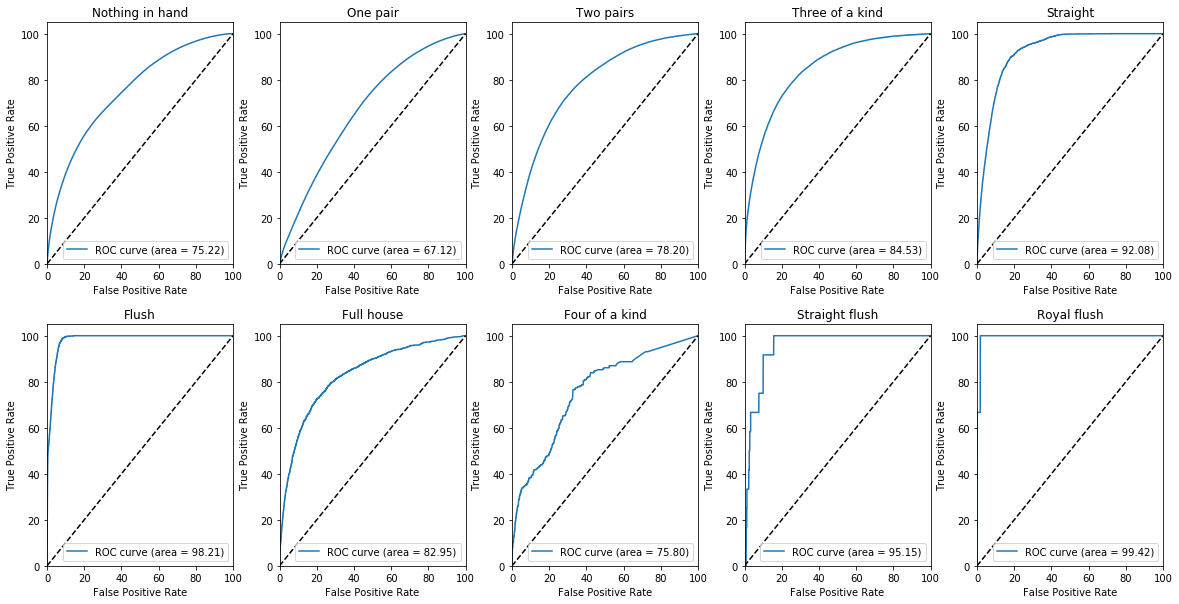

In [32]:
plot_roc_curve(y_test, y_score, poker_hand, classes=[0,1,2,3,4,5,6,7,8,9])

## Limpando a memória para novas execuções

In [34]:
del cnf_matrix, clf, y_pred, y_score

# SVM

Abreviada como SVM, e conhecida como *Support Vector Machines*, esta técnica trabalha com três tipos de funcionalidades, e que deve ser escolhida para trabalhar: **(a) Linear**, **(b) Polinomial** e **(c) Gaussiana**.

Para este trabalho, está sendo abordado a funcionalidade Linear e esta apresenta um custo $O(max(n,d) * min(n,d)^2)$, onde $n$ representa o número de registros e $d$ o número de atributos analisados.

Ainda, a escolha de uma dessas da atuação com *One-vs-One* ou *One-vs-All* (*One-vs-Rest*).


|OVO vs OVA |  Margin |
|:-------------------------:|:-------------------------:|
|![OVO-vs-OVA](./img/ovo_ova.png) |  ![ROC Curve](./img/svm_linear_margin.png)|

In [35]:
C_range = np.logspace(-1, -12, 13)
gamma_range = np.logspace(-3, 2, 6)
max_iter_range = np.random.randint(1000, size=100)

param_grid = dict(gamma=gamma_range, 
                  C=C_range, 
                  max_iter=max_iter_range,
                  kernel=['linear', 'rbf', 'sigmoid', 'poly'],
                  decision_function_shape=['ovo','ovr'],
                  probability=[True])

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)
clf = RandomizedSearchCV(SVC(), 
                         param_distributions=param_grid, 
                         cv=cv, 
                         verbose=1, 
                         n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.4min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'C': array([1.00000e-01, 1.21153e-02, 1.46780e-03, 1.77828e-04, 2.15443e-05,
       2.61016e-06, 3.16228e-07, 3.83119e-08, 4.64159e-09, 5.62341e-10,
       6.81292e-11, 8.25404e-12, 1.00000e-12]), 'max_iter': array([930, 524, ..., 450, 863]), 'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 'decision_function_shape': ['ovo', 'ovr'], 'probability': [True]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_trai

In [38]:
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'probability': True, 'max_iter': 369, 'kernel': 'sigmoid', 'gamma': 100.0, 'decision_function_shape': 'ovo', 'C': 1e-12} with a score of 0.50


In [36]:
clf.best_estimator_

SVC(C=1e-12, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=100.0, kernel='sigmoid',
  max_iter=369, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
clf = SVC(C=2.6101572156825386e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=486, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
clf.fit(X_train, y_train)

SVC(C=2.6101572156825386e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=486, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Avaliando resultados do modelo treinado

In [43]:
y_pred = clf.predict(X_test)

### Acurária e métricas internas de cada classe

In [44]:
print("Acurácia = ", (metrics.accuracy_score(y_test, y_pred) * 100))
print("Precisão e Recall para cada Classe")
print(metrics.classification_report(y_test, y_pred))

Acurácia =  36.7544
Precisão e Recall para cada Classe
             precision    recall  f1-score   support

          0       0.48      0.37      0.42    501209
          1       0.43      0.42      0.42    422498
          2       0.04      0.10      0.05     47622
          3       0.01      0.05      0.02     21121
          4       0.00      0.00      0.00      3885
          5       0.00      0.00      0.00      1996
          6       0.00      0.00      0.00      1424
          7       0.00      0.00      0.00       230
          8       0.00      0.00      0.00        12
          9       0.00      0.00      0.00         3

avg / total       0.43      0.37      0.39   1000000



### ROC Curve

In [45]:
y_score = clf.predict_proba(X_test)

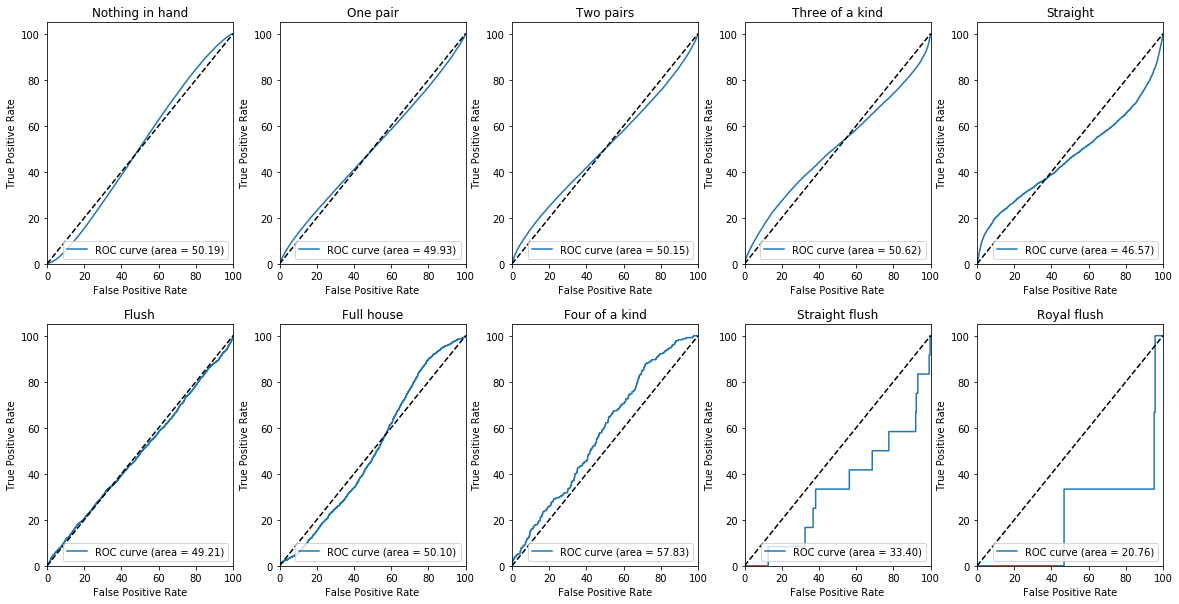

In [46]:
plot_roc_curve(y_test, y_score, poker_hand, classes=[0,1,2,3,4,5,6,7,8,9])

## Limpando a memória para novas execuções

In [ ]:
del cnf_matrix, clf, y_pred, y_score

# Neural Network - com Keras e Tensorflow

Dificilmente de mensurar a complexidade quando se trata de *Neural Networks*, pois depende, conforme imagem abaixo, pode-se superficialmente considerar o custo como $O(n^{2}*H)$, onde $n$ representa o número de neurônios e $H$ a quantidade de camadas de neurônios utilizadas para o desenvolvimento em uma arquitetura padrão.

<center><img src="./img/nn_zoo.png" alt="Zoo" width="45%"/></center>

## Adaptando as classes para a entrada em Neural Networks

In [18]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

## Primeiro modelo

In [50]:
model_1 = Sequential()
model_1.add(Dense(16, input_shape=(10,), kernel_initializer='uniform', activation='relu'))
model_1.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
time_callback = TimeHistory()
model_results = model_1.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1, callbacks=[time_callback])

Epoch 1/100
25010/25010 [==============================] - 2s 87us/step - loss: 0.9371 - acc: 0.5565
Epoch 2/100
25010/25010 [==============================] - 2s 85us/step - loss: 0.9368 - acc: 0.5559
Epoch 3/100
25010/25010 [==============================] - 2s 91us/step - loss: 0.9372 - acc: 0.5583
Epoch 4/100
25010/25010 [==============================] - 2s 84us/step - loss: 0.9364 - acc: 0.5562
Epoch 5/100
25010/25010 [==============================] - 2s 88us/step - loss: 0.9359 - acc: 0.5588
Epoch 6/100
25010/25010 [==============================] - 2s 86us/step - loss: 0.9354 - acc: 0.5575
Epoch 7/100
25010/25010 [==============================] - 2s 86us/step - loss: 0.9353 - acc: 0.5580
Epoch 8/100
25010/25010 [==============================] - 2s 78us/step - loss: 0.9344 - acc: 0.5589
Epoch 9/100
25010/25010 [==============================] - 2s 69us/step - loss: 0.9346 - acc: 0.5614
Epoch 10/100
25010/25010 [==============================] - 2s 70us/step - loss: 0.9347 - a

In [53]:
print(sum(time_callback.times))

181.6978952884674


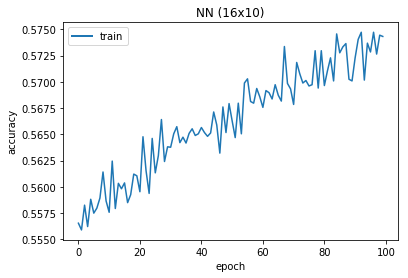

In [54]:
plot_accuracy_nn(model_results, title='NN (16x10)')

In [55]:
loss, accuracy = model_1.evaluate(X_train, Y_train, verbose=0)
print("Train: accuracy=%f loss=%f" % (accuracy, loss))

Train: accuracy=0.578968 loss=0.910036


### Limpando a memória

In [56]:
del model_1, model_results

## Modelo 2 (50 x 50 x 10 - 200 iterações)

In [ ]:
model2 = Sequential()
model2.add(Dense(50, input_shape=(10,), kernel_initializer='uniform', activation='relu'))
model2.add(Dense(50, kernel_initializer='uniform', activation='relu'))
model2.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
time_callback = TimeHistory()
model_results = model2.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=200,
    shuffle=True,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/200
25010/25010 [==============================] - 2s 95us/step - loss: 0.6591 - acc: 0.7345
Epoch 2/200
25010/25010 [==============================] - 2s 98us/step - loss: 0.6426 - acc: 0.7453
Epoch 3/200
25010/25010 [==============================] - 2s 98us/step - loss: 0.6449 - acc: 0.7429
Epoch 4/200
25010/25010 [==============================] - 2s 88us/step - loss: 0.6323 - acc: 0.7485
Epoch 5/200
25010/25010 [==============================] - 2s 94us/step - loss: 0.6224 - acc: 0.7533
Epoch 6/200
25010/25010 [==============================] - 2s 99us/step - loss: 0.6258 - acc: 0.7507
Epoch 7/200
25010/25010 [==============================] - 2s 88us/step - loss: 0.6063 - acc: 0.7627
Epoch 8/200
25010/25010 [==============================] - 2s 92us/step - loss: 0.6056 - acc: 0.7647
Epoch 9/200
25010/25010 [==============================] - 2s 86us/step - loss: 0.6024 - acc: 0.7637
Epoch 10/200
25010/25010 [==============================] - 2s 95us/step - loss: 0.5874 - a

In [22]:
print(sum(time_callback.times))

391.98457312583923


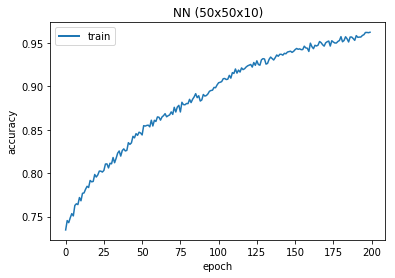

In [23]:
plot_accuracy_nn(model_results, title='NN (50x50x10)')

In [24]:
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=0)
print("Test: accuracy=%f loss=%f" % (accuracy, loss))

Test: accuracy=0.962853 loss=0.115329


In [87]:
y_score = model2.predict_proba(X_test)

In [86]:
print(metrics.classification_report(y_test, np.argmax(y_score, axis=1)))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98    501209
          1       0.97      0.98      0.97    422498
          2       0.85      0.84      0.85     47622
          3       0.83      0.81      0.82     21121
          4       0.74      0.12      0.20      3885
          5       0.50      0.01      0.03      1996
          6       0.73      0.19      0.30      1424
          7       0.33      0.18      0.24       230
          8       0.00      0.00      0.00        12
          9       0.00      0.00      0.00         3

avg / total       0.96      0.96      0.96   1000000



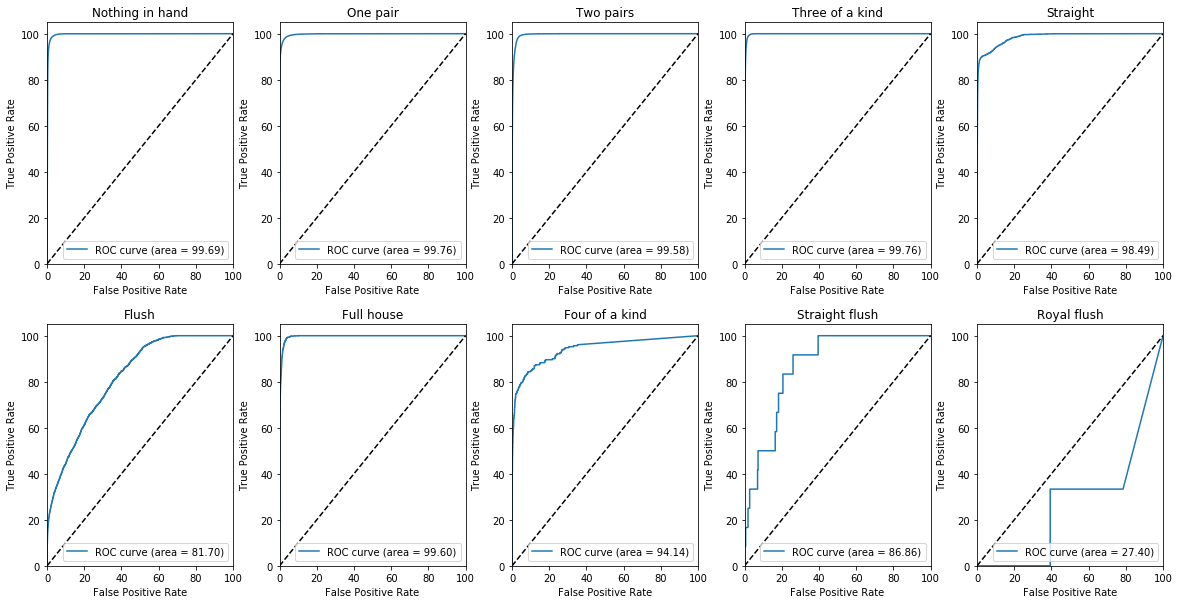

In [85]:
plot_roc_curve(y_test, y_score, poker_hand, classes=[0,1,2,3,4,5,6,7,8,9])

## Modelo 3 (200 x 400 x 200 x 10 - 100 iterações)

In [89]:
model3 = Sequential()
model3.add(Dense(200, input_shape=(10,), kernel_initializer='uniform', activation='relu'))
model3.add(Dense(400, kernel_initializer='uniform', activation='relu'))
model3.add(Dense(200, kernel_initializer='uniform', activation='relu'))
model3.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
time_callback = TimeHistory()
model_results = model3.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=100,
    shuffle=True,
    verbose=1,
    callbacks=[time_callback]
)

Epoch 1/100
25010/25010 [==============================] - 4s 177us/step - loss: 1.0040 - acc: 0.4852
Epoch 2/100
25010/25010 [==============================] - 4s 170us/step - loss: 0.9719 - acc: 0.5245
Epoch 3/100
25010/25010 [==============================] - 4s 148us/step - loss: 0.9555 - acc: 0.5450
Epoch 4/100
25010/25010 [==============================] - 4s 165us/step - loss: 0.9456 - acc: 0.5531
Epoch 5/100
25010/25010 [==============================] - 4s 153us/step - loss: 0.9380 - acc: 0.5570
Epoch 6/100
25010/25010 [==============================] - 4s 155us/step - loss: 0.9261 - acc: 0.5665
Epoch 7/100
25010/25010 [==============================] - 4s 164us/step - loss: 0.9159 - acc: 0.5729
Epoch 8/100
25010/25010 [==============================] - 4s 173us/step - loss: 0.8953 - acc: 0.5857
Epoch 9/100
25010/25010 [==============================] - 4s 171us/step - loss: 0.8720 - acc: 0.6025
Epoch 10/100
25010/25010 [==============================] - 4s 177us/step - loss: 

In [91]:
print(sum(time_callback.times))

405.105504989624


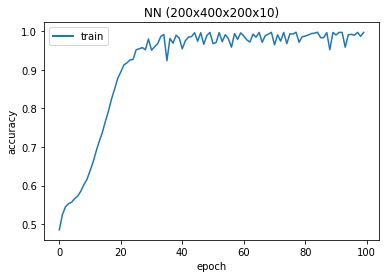

In [105]:
plot_accuracy_nn(model_results, title='NN (200x400x200x10)')

In [106]:
loss, accuracy = model3.evaluate(X_test, Y_test, verbose=0)
print("Test: accuracy=%f loss=%f" % (accuracy, loss))

Test: accuracy=0.997284 loss=0.025922


In [107]:
y_score = model3.predict_proba(X_test)

In [108]:
print(metrics.classification_report(y_test, np.argmax(y_score, axis=1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    501209
          1       1.00      1.00      1.00    422498
          2       1.00      1.00      1.00     47622
          3       1.00      1.00      1.00     21121
          4       0.97      0.90      0.94      3885
          5       0.05      0.00      0.00      1996
          6       0.95      0.96      0.96      1424
          7       0.99      0.68      0.81       230
          8       0.00      0.00      0.00        12
          9       0.00      0.00      0.00         3

avg / total       1.00      1.00      1.00   1000000



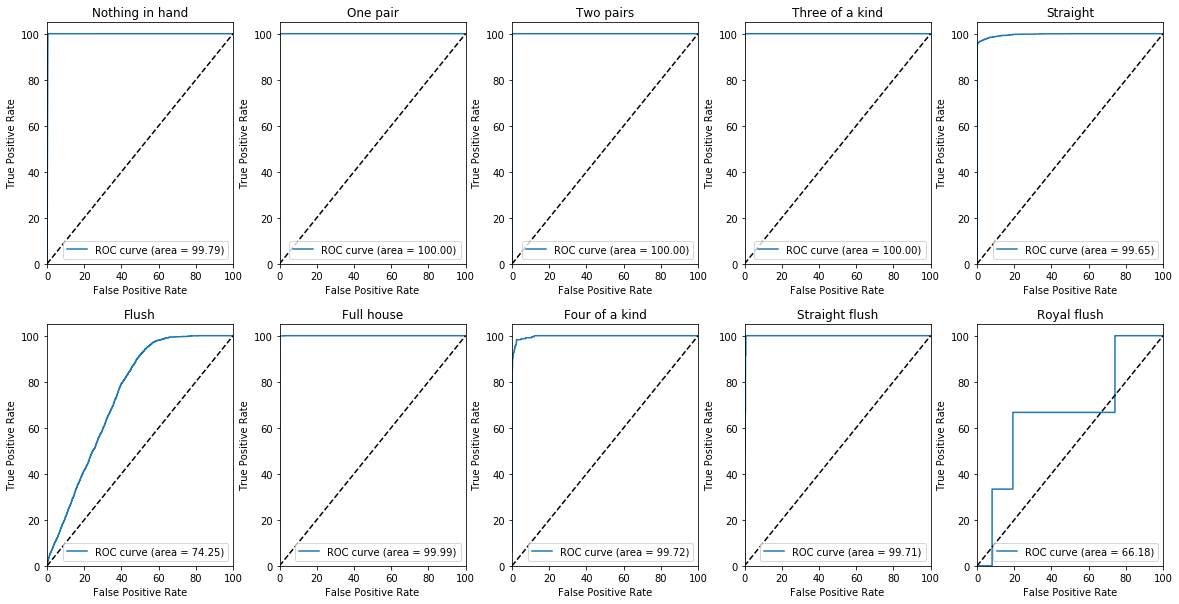

In [109]:
plot_roc_curve(y_test, y_score, poker_hand, classes=[0,1,2,3,4,5,6,7,8,9])

# Explorando algumas técnicas

In [26]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

In [54]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys

space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                    {'layers':'three',
                    'units3': hp.uniform('units3', 64,1024), 
                    'dropout3': hp.uniform('dropout3', .25,.75)}
                    ]),

            'units1': hp.uniform('units1', 64,1024),
            'units2': hp.uniform('units2', 64,1024),

            'dropout1': hp.uniform('dropout1', .25,.75),
            'dropout2': hp.uniform('dropout2',  .25,.75),

            'batch_size' : hp.uniform('batch_size', 28,128),
         
            'epochs' :  100,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

def f_nn(params):   
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.optimizers import Adadelta, Adam, rmsprop

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(output_dim=params['units1'], input_dim = X.shape[0])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

#     model.add(Dense(output_dim=params['units2'], kernel_initializer = "glorot_uniform")) 
#     model.add(Activation(params['activation']))
#     model.add(Dropout(params['dropout2']))

#     if params['choice']['layers']== 'three':
#         model.add(Dense(output_dim=params['choice']['units3'], kernel_initializer = "glorot_uniform")) 
#         model.add(Activation(params['activation']))
#         model.add(Dropout(params['choice']['dropout3']))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, nb_epoch=params['nb_epochs'], 
              batch_size=params['batch_size'], verbose = 0)

    pred_auc = model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = metrics.roc_auc_score(y_val, pred_auc)
    print('AUC:', acc)
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}

In [30]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

In [112]:
def cross_validate_mlp(mlp_func, nfolds=10, epochs=30):
    folds = KFold(n_splits=nfolds, shuffle=True, random_state = 0)
    val_scores = np.zeros((nfolds,))
    
    train_x = np.array(X_train)
    train_Y = np.array(Y_train)
    
    for k,(train_index, test_index) in enumerate(folds.split(train_x)):
        xtr = train_x[train_index]
        ytr = train_Y[train_index]
        xte = train_x[test_index]
        yte = train_Y[test_index]
        mlp = mlp_func()
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)
        fit = mlp.fit(xtr, ytr, 
                      validation_split=0.2, 
                      batch_size=128, 
                      epochs=100,
                      verbose=0,
                      callbacks=[early_stopping])
        pred = mlp.predict(xte, batch_size=256)
        
        score = metrics.mean_absolute_error(yte, pred)
        val_scores[k] += score
        print('Fold {}, MAE: {}'.format(k, score))
        
    avg_score = np.sum(val_scores) / float(nfolds)
    print('{}-fold CV score: {}'.format(nfolds, avg_score))
    return avg_score

In [108]:
# Describing the search space
space = {
    'hidden1_units': hp.choice('hidden1_units', np.linspace(10,200,50,dtype='int32')),
    'hidden1_dropout': hp.choice('hidden1_dropout', np.linspace(0.4,0.6,20)),
    'hidden2_units': hp.choice('hidden2_units', np.linspace(10,200,50,dtype='int32')),
    'hidden2_dropout': hp.choice('hidden2_dropout', np.linspace(0.2,0.5,10)),
    'hidden3_units': hp.choice('hidden3_units', np.linspace(10,100,20,dtype='int32')),
    'hidden3_dropout': hp.choice('hidden3_dropout', np.linspace(0.1,0.5,10)),
    'optimizer': hp.choice('optimizer', ['adam','nadam','adamax','adadelta']),
    'epochs': hp.choice('epochs', np.linspace(10,200,50,dtype='int32').tolist())
}

In [109]:
nb_classes = 10

In [113]:
# Implementing a function to minimize
def hyperopt_search(params):
    print('Model Testing:', params)
    
    def mlp_model():
        model = Sequential()
        model.add(Dense(params['hidden1_units'], 
                        input_dim = X_train.shape[1],
                        kernel_initializer = 'uniform', 
                        activation = 'relu'))
#        model.add(BatchNormalization())
        model.add(Dropout(params['hidden1_dropout']))
        
        model.add(Dense(params['hidden2_units'],
                        kernel_initializer = 'uniform', 
                        activation = 'relu'))
#        model.add(BatchNormalization())
        model.add(Dropout(params['hidden2_dropout']))

        model.add(Dense(params['hidden3_units'],
                        kernel_initializer = 'uniform', 
                        activation = 'relu')) 
#         model.add(BatchNormalization())
        model.add(Dropout(params['hidden3_dropout']))
        
        model.add(Dense(nb_classes, 
                        kernel_initializer='uniform', 
                        activation='softmax'))
        
        model.compile(loss='categorical_crossentropy', 
                      optimizer=params['optimizer'],
                      metrics=['accuracy'])
        return model
    
    mae = cross_validate_mlp(mlp_model, nfolds=10, epochs=params['epochs'])
    return {'mae': mae, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(hyperopt_search, space, algo=tpe.suggest, max_evals = 3, trials=trials)

Model Testing: {'epochs': 52, 'hidden1_dropout': 0.5368421052631579, 'hidden1_units': 114, 'hidden2_dropout': 0.33333333333333337, 'hidden2_units': 48, 'hidden3_dropout': 0.4111111111111111, 'hidden3_units': 76, 'optimizer': 'adamax'}
Fold 0, MAE: 0.10933218582942598
Fold 1, MAE: 0.10851467856919927
Fold 2, MAE: 0.1106369346268671
Fold 3, MAE: 0.1109211493861489
